In [8]:
from nipype.interfaces.ants import Registration
from nipype.interfaces.ants import ApplyTransforms
from nipype import Node, Workflow, MapNode
import nipype.interfaces.fsl as fsl
import nipype.interfaces.afni as afni
from nipype.interfaces.robex.preprocess import RobexSegment
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from os.path import join

def select_volume(filename, which):
    """Return the middle index of a file
    """
    from nibabel import load
    import numpy as np
    
    if which.lower() == 'first':
        idx = 0
    elif which.lower() == 'middle':
        idx = int(np.ceil(load(filename).shape[3]/2))
    else:
        raise Exception('unknown value for volume selection : %s'%which)
        
    return idx

def get_reg_wf(reg_type='func', name='func_reg_wf'): 
    """
    Return the registration workflow for direct EPI-to-template registration. 
    """
    # fetch input 
    inputnode = Node(IdentityInterface(fields=['in_file', 'template']),
                        name='inputnode')
    
    outputnode = Node(IdentityInterface(fields=['registered_image']), 
                        name='outputnode')
    
    extract_ref = Node(interface=fsl.ExtractROI(t_size=1),
                      name = 'extractref')
    
    # registration or normalization step based on symmetric diffeomorphic image registration (SyN) using ANTs 
    reg = Node(Registration(), name='NormalizationAnts')
    reg.inputs.output_transform_prefix = f'{reg_type}2template'
    reg.inputs.output_warped_image = f'{reg_type}2template.nii.gz'
    reg.inputs.output_transform_prefix = f'{reg_type}2template_'
    reg.inputs.transforms = ['Rigid','Affine', 'SyN']
    reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.2, 3.0, 0.0)]
    reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 2 + [[40, 10, 5]])
    reg.inputs.dimension = 3
    reg.inputs.write_composite_transform = True
    reg.inputs.collapse_output_transforms = True
    reg.inputs.initial_moving_transform_com = True
    reg.inputs.metric = ['Mattes'] * 2 + [['Mattes', 'CC']]
    reg.inputs.metric_weight = [1] * 2 + [[0.5, 0.5]]
    reg.inputs.radius_or_number_of_bins = [32] * 2 + [[32, 4]]
    reg.inputs.sampling_strategy = ['Regular'] * 2 + [[None, None]]
    reg.inputs.sampling_percentage = [0.3] * 2 + [[None, None]]
    reg.inputs.convergence_threshold = [1.e-8] * 2 + [-0.01]
    reg.inputs.convergence_window_size = [20] * 2 + [5]
    reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 2 + [[1, 0.5, 0]]
    reg.inputs.sigma_units = ['vox'] * 3
    reg.inputs.shrink_factors = [[3, 2, 1]]*2 + [[4, 2, 1]]
    reg.inputs.use_estimate_learning_rate_once = [True] * 3
    reg.inputs.use_histogram_matching = [False] * 2 + [True]
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995
    reg.inputs.args = '--float'
    
    # apply the transform 
    apply_trans_func = Node(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    terminal_output='file'), 
                            name='apply_trans_func')
    
    reg_wf = Workflow(name=name, base_dir= output_dir)    

    if reg_type=='func':
        reg_wf.connect(
            [
                (inputnode, extract_ref, [('in_file', 'in_file'),
                                      (('in_file', select_volume, 'middle'), 't_min')]),
                (extract_ref, reg, [('roi_file', 'moving_image')]), 
            ]
        )
    else: 
        reg_wf.connect(
            [
                (inputnode, reg, [('in_file', 'moving_image')])
            ]
        )
    
    reg_wf.connect(
        [
           (inputnode, reg, [('template', 'fixed_image')]),
           (inputnode, apply_trans_func, [('template', 'reference_image'),
                                           ('in_file', 'input_image')]),
           (reg, apply_trans_func, [('composite_transform', 'transforms')]),
           (apply_trans_func, outputnode, [('output_image', 'registered_image')])
        ]
    )
    
    return reg_wf 

def create_preproc_wf(data_dir, output_dir, subject_list):
    # IdentityInterface node - allows to iterate over subjects and runs
    info_source = Node(
        IdentityInterface(fields=['subject_id']),
        name='info_source'
    )
    info_source.iterables = [
        ('subject_id', subject_list)
    ]
    
    # Templates to select files node
    file_templates = {
        'anat': join(
            'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz'
            ),
        'func': join(
            'sub-{subject_id}', 'func', 'sub-{subject_id}_task-rest_bold.nii.gz'
            )
    }
    
    # SelectFiles node - to select necessary files
    select_files = Node(
        SelectFiles(file_templates, base_directory = data_dir),
        name='select_files'
    )
    
    # DataSink Node - store the wanted results in the wanted repository
    data_sink = Node(
        DataSink(base_directory = output_dir),
        name='data_sink',
    )

    extract_ref = Node(
        interface=fsl.ExtractROI(t_size=1),
        name='extractref')

    motion_correction = Node(
        fsl.MCFLIRT(dof=6),
        name='motion_correction'
    )

    skullstrip_func = Node(
        afni.Automask(),
        name='skullstrip_func'
    )

    non_linear_registration_anat = get_reg_wf('anat', 'anat_reg_wf')
    non_linear_registration_anat.inputs.inputnode.template=fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')
    
    non_linear_registration_func = get_reg_wf('func', 'func_reg_wf')
    non_linear_registration_func.inputs.inputnode.template=fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')

    ica_aroma = Node(
        fsl.ICA_AROMA(out_dir=output_dir), 
        name='ica_aroma'
    )

    brain_extraction_anat = Node(
        RobexSegment(),
        name='anat_bet'
    )

    segment = Node(
        fsl.FAST(),
        name='segment'
    )

    preproc_wf = Workflow(name='preproc_wf')
    preproc_wf.base_dir = output_dir

    preproc_wf.connect(
        [
            (info_source, select_files, [('subject_id', 'subject_id')]),
            (select_files, motion_correction, [('func', 'in_file')]),
            (select_files, extract_ref, [(('func', select_volume, 'middle'), 't_min'),
                                         ('func', 'in_file')]),
            (extract_ref, motion_correction, [('roi_file', 'ref_file')]),
            (motion_correction, skullstrip_func, [('out_file', 'in_file')]),
            (skullstrip_func, non_linear_registration_func, [('out_file', 'inputnode.in_file')]),
            #(select_files, non_linear_registration_anat, [('anat', 'inputnode.in_file')]),
            #(non_linear_registration_anat, brain_extraction_anat, [('outputnode.registered_image', 'in_file')]),
            #(select_files, brain_extraction_anat, [('anat', 'in_file')]),
            #(brain_extraction_anat, segment, [('out_file', 'in_files')]),
            (non_linear_registration_func, ica_aroma, [('outputnode.registered_image', 'in_file')]),
            (motion_correction, ica_aroma, [('par_file', 'motion_parameters')]),
            (motion_correction, data_sink, [('par_file', 'results.@motion_param')]),
            (non_linear_registration_func, data_sink, [('outputnode.registered_image', 'results.@registered')]),
            (ica_aroma, data_sink,[('nonaggr_denoised_file', 'results.@nonaggr_file'),
                                  ('out_dir', 'results.@result_dir')]),
            #(segment, data_sink, [('tissue_class_map', 'results.@segmap'), 
            #                     ('tissue_class_files', 'results.@segfiles')])
        ]
    )

    return preproc_wf

In [9]:
data_dir = '/home/nguyen-etal-2021/inputs/data/Nifti'
output_dir = '/home/nguyen-etal-2021/outputs'
subject_list = ['3107']

preproc_wf = create_preproc_wf(data_dir, output_dir, subject_list)

230906-17:41:07,48 nipype.workflow INFO:
	 Generated workflow graph: ./graph_colored.png (graph2use=colored, simple_form=True).


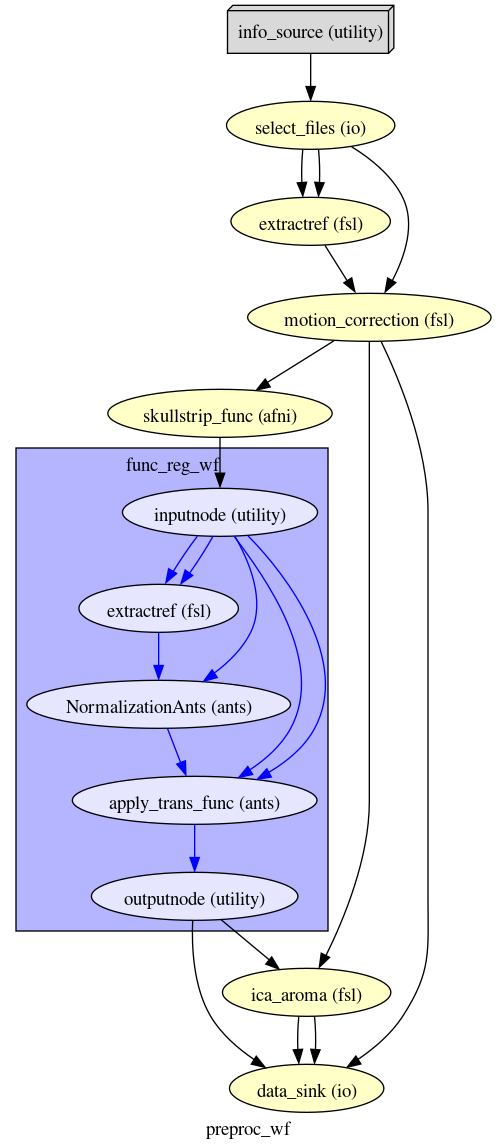

In [10]:
# Write graph of type colored
preproc_wf.write_graph(graph2use='colored', dotfilename='./graph_colored.dot')

# Visualize graph
from IPython.display import Image
Image(filename="graph_colored.png")

In [11]:
preproc_wf.run()

230906-17:41:38,699 nipype.workflow INFO:
	 Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']
230906-17:41:38,850 nipype.workflow INFO:
	 Running serially.
230906-17:41:38,855 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.select_files" in "/home/nguyen-etal-2021/.cache/outputs/preproc_wf/_subject_id_3107/select_files".
230906-17:41:38,874 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc_wf.select_files".
230906-17:41:38,947 nipype.workflow INFO:
	 [Node] Executing "select_files" <nipype.interfaces.io.SelectFiles>
230906-17:41:38,965 nipype.workflow INFO:
	 [Node] Finished "select_files", elapsed time 0.011778s.
230906-17:41:39,5 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.extractref" in "/home/nguyen-etal-2021/.cache/outputs/preproc_wf/_subject_id_3107/extractref".
230906-17:41:39,67 nipype.workflow INFO:
	 [Node] Cached "preproc_wf.extractref" - collecting precomputed outputs
230906-17:41:39,69 nipype.workflow INFO:
	 [Node

NodeExecutionError: Exception raised while executing Node extractref.

Cmdline:
	fslroi /home/nguyen-etal-2021/.cache/outputs/preproc_wf/_subject_id_3107/skullstrip_func/sub-3107_task-rest_bold_mcf_mask+orig.BRIK /home/nguyen-etal-2021/.cache/outputs/preproc_wf/func_reg_wf/_subject_id_3107/extractref/sub-3107_task-rest_bold_mcf_mask+orig_roi.nii.gz 1 1
Stdout:

Stderr:
	Image Exception : #63 :: No image files match: /home/nguyen-etal-2021/.cache/outputs/preproc_wf/_subject_id_3107/skullstrip_func/sub-3107_task-rest_bold_mcf_mask+orig.BRIK
	No image files match: /home/nguyen-etal-2021/.cache/outputs/preproc_wf/_subject_id_3107/skullstrip_func/sub-3107_task-rest_bold_mcf_mask+orig.BRIK
Traceback:
	Traceback (most recent call last):
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/nipype/interfaces/base/core.py", line 454, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'roi_file' trait of an ExtractROIOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/nguyen-etal-2021/.cache/outputs/preproc_wf/func_reg_wf/_subject_id_3107/extractref/sub-3107_task-rest_bold_mcf_mask+orig_roi.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/nipype/interfaces/base/core.py", line 401, in run
	    outputs = self.aggregate_outputs(runtime)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.10/site-packages/nipype/interfaces/base/core.py", line 461, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/nguyen-etal-2021/.cache/outputs/preproc_wf/func_reg_wf/_subject_id_3107/extractref/sub-3107_task-rest_bold_mcf_mask+orig_roi.nii.gz' for output 'roi_file' of a ExtractROI interface
